## PS3 ##
### Yuqian Gong ###

## Question 1 ##

#### (a) ####

In [124]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib notebook

<IPython.core.display.Javascript object>


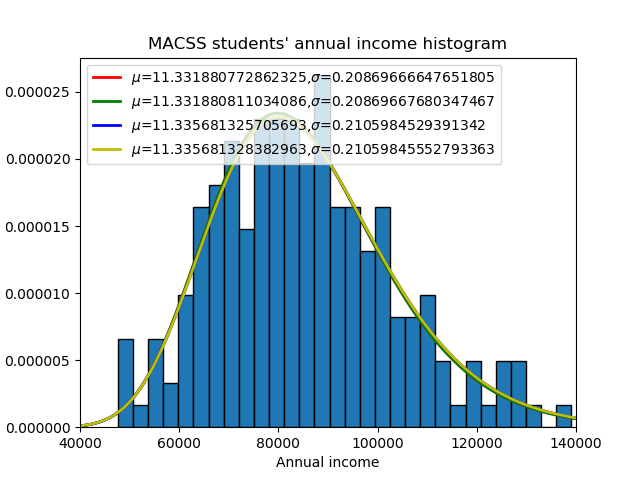

(40000, 140000)

In [125]:
pts = np.loadtxt('income.txt')
plt.figure(1)
count, bins, ignored = plt.hist(pts, 30, edgecolor = "black", normed = True)
plt.title("MACSS students' annual income histogram")
plt.xlabel("Annual income")
plt.ylabel('percentage of income')
plt.xlim([40000, 140000])

### (b) ###

In [126]:
def lognormal_pdf(xvals, mu, sigma):
    pdf_vals = (1/(xvals * sigma * np.sqrt(2 * np.pi))) * \
               np.exp(-(np.log(xvals) - mu)**2 / (2 * sigma **2))
    return pdf_vals

def data_moments(xvals):
    mean_data = xvals.mean()
    std_data= xvals.std()
    return mean_data, std_data

def model_moments(mu, sigma):
    mean_model = np.exp(mu + (sigma ** 2)/2)
    std_model = np.sqrt(np.exp(2 * mu + 2* (sigma ** 2)) - np.exp(2* mu + sigma ** 2))
    return mean_model, std_model

def err_vec(xvals, mu, sigma, simple):
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data)/ moms_data
        
    return err_vec

def crit(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple = False)
    crit_val = np.dot(np.dot(err.T, W), err)
    return crit_val
dist_pts = np.linspace(0, 150000, 500)
def plot_pdf(mu, sigma, dist_pts, color):
    plt.figure(1)
    plt.plot(dist_pts, lognormal_pdf(dist_pts, mu, sigma),
            linewidth=2, color= color, label='$\mu$={},$\sigma$={}'.format(mu, sigma))
    plt.legend(loc='upper left')
    


In [127]:
mu_init = 11
sigma_init = 0.5
params_init = np.array([mu_init, sigma_init])
W_hat = np.eye(2)
gmm_args = (pts, W_hat)
def get_optimal(function, params_init, gmm_args):
    results = opt.minimize(function, params_init, args=(gmm_args),\
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
    return results
results = get_optimal(crit, params_init, gmm_args)
mu_GMM1, sigma_GMM1 = results.x
crit_val = results.fun
plot_pdf(mu_GMM1, sigma_GMM1, dist_pts, 'r')
print("The estimated mu and sigma from GMMA are {} and {} respectively".format(mu_GMM1, sigma_GMM1))
print("The two data moments are {} and {}".format(data_moments(pts)[0], data_moments(pts)[1]))
print("The two model moments are {} and {}".format(model_moments(mu_GMM1, sigma_GMM1)[0], model_moments(mu_GMM1, \
                                                                                                       sigma_GMM1)[1]))
print("The value of the criterian function is {}".format(crit_val))

The estimated mu and sigma from GMMA are 11.331880772862325 and 0.20869666647651805 respectively
The two data moments are 85276.82360625811 and 17992.542128046523
The two model moments are 85276.81764531012 and 17992.54129877101
The value of the criterian function is [[  7.01045493e-15]]


/Users/XiuyuanZhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/XiuyuanZhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/XiuyuanZhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


### (c) ###

In [128]:
err1 = err_vec(pts, mu_GMM1, sigma_GMM1, simple = False)
VCV2 = np.dot(err1, err1.T)/ pts.shape[0]
W_hat2 = lin.pinv(VCV2)
print(W_hat2)

[[  1.98841132e+16   1.31107707e+16]
 [  1.31107707e+16   8.64470580e+15]]


In [129]:
params_init = np.array([mu_GMM1, sigma_GMM1])
gmm_args = (pts, W_hat2)
results2 = get_optimal(crit, params_init, gmm_args)
mu_GMM2, sigma_GMM2 = results2.x
crit_val2= results2.fun
plot_pdf(mu_GMM2, sigma_GMM2, dist_pts, 'g')
print("The estimated mu and sigma from GMM are {} and {} respectively".format(mu_GMM2, sigma_GMM2))
print("The two data moments are {} and {}".format(data_moments(pts)[0], data_moments(pts)[1]))
print("The two model moments are {} and {}".format(model_moments(mu_GMM2, sigma_GMM2)[0], model_moments(mu_GMM2, \
                                                                                                       sigma_GMM2)[1]))
print("The value of the criterian function is {}".format(crit_val2))

The estimated mu and sigma from GMM are 11.331880811034086 and 0.20869667680347467 respectively
The two data moments are 85276.82360625811 and 17992.542128046523
The two model moments are 85276.82108426512 and 17992.542934212786
The value of the criterian function is [[  1.93866308e-05]]


/Users/XiuyuanZhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/XiuyuanZhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/XiuyuanZhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


### (d) ###

In [130]:
def data_moments2(xvals):
    num_x = xvals.shape[0]
    data_1 = xvals[xvals < 75000].shape[0]/num_x
    data_2 = xvals[(xvals >= 75000) & (xvals <= 100000)].shape[0]/num_x
    data_3 = xvals[xvals > 100000].shape[0]/num_x
    return data_1, data_2, data_3

def model_moments2(mu, sigma):
    model_1= norm.cdf((np.log(75000) - mu)/sigma)
    model_2 = norm.cdf((np.log(100000)- mu)/sigma) - model_1
    model_3 = 1 - norm.cdf((np.log(100000) - mu)/sigma)
    return model_1, model_2, model_3


def err_vec1(xvals, mu, sigma, simple):
    data_1, data_2, data_3 = data_moments2(xvals)
    moms_data = np.array([[data_1], [data_2], [data_3]])
    model_1, model_2, model_3 = model_moments2(mu, sigma)
    moms_model = np.array([[model_1], [model_2], [model_3]])
    if simple:
        err_vec1 = moms_model/moms_data
    else:
        err_vec1 = (moms_model - moms_data)/moms_data
    return err_vec1



def crit1(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec1(xvals, mu, sigma, simple = False)
    crit_val = np.dot(np.dot(err.T, W), err)
    return crit_val
    

In [131]:
mu_init = 11
sigma_init = 0.5
params3_init = np.array([mu_init, sigma_init])
W_hat3 = np.eye(3)
gmm_args3 = (pts, W_hat3)
results3 = opt.minimize(crit1, params3_init, args=(gmm_args3),\
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM3, sigma_GMM3 = results3.x
crit_val3 = results3.fun
plot_pdf(mu_GMM3, sigma_GMM3, dist_pts, 'b')
print("The estimated mu and sigma from GMM are {} and {} respectively".format(mu_GMM3, sigma_GMM3))
print("The three data moments are {}, {} and {}".format(data_moments2(pts)[0], data_moments2(pts)[1], data_moments2(pts)[2]))
print("The three model moments are {}, {} and {}".format(model_moments2(mu_GMM3, sigma_GMM3)[0], model_moments2(mu_GMM3, \
                                                   sigma_GMM3)[1], model_moments2(mu_GMM3, sigma_GMM3)[2]))
print("The value of the criterian function is {}".format(crit_val3))

The estimated mu and sigma from GMM are 11.335681325705693 and 0.2105984529391342 respectively
The three data moments are 0.3, 0.5 and 0.2
The three model moments are 0.30000000579418706, 0.5000000068525199 and 0.19999998735329305
The value of the criterian function is [[  4.55933697e-15]]


/Users/XiuyuanZhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/XiuyuanZhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/XiuyuanZhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


### (e) ###

In [132]:
err3 = err_vec1(pts, mu_GMM3, sigma_GMM3, simple = False)
VCV = np.dot(err3, err3.T)/ pts.shape[0]
W_hat3 = lin.pinv(VCV)
print(W_hat3)

[[  3.58896423e+15   2.54670225e+15  -1.17502020e+16]
 [  2.54670225e+15   1.80712092e+15  -8.33785568e+15]
 [ -1.17502020e+16  -8.33785568e+15   3.84699422e+16]]


In [133]:
params4_init = np.array([mu_GMM3, sigma_GMM3])
gmm_args4 = (pts, W_hat3)
results4 = get_optimal(crit1, params4_init, gmm_args4)
mu_GMM4, sigma_GMM4 = results4.x
crit_val4= results4.fun
plot_pdf(mu_GMM4, sigma_GMM4, dist_pts, 'y')
print("The estimated mu and sigma from GMM are {} and {} respectively".format(mu_GMM4, sigma_GMM4))
print("The two data moments are {}, {} and {}".format(data_moments2(pts)[0], data_moments2(pts)[1], data_moments2(pts)[2]))
print("The two model moments are {}, {} and {}".format(model_moments2(mu_GMM4, sigma_GMM4)[0], model_moments2(mu_GMM4, \
                                                                  sigma_GMM4)[1], model_moments2(mu_GMM4, sigma_GMM4)[2]))
print("The value of the criterian function is {}".format(crit_val4))

The estimated mu and sigma from GMM are 11.335681328382963 and 0.21059845552793363 respectively
The two data moments are 0.3, 0.5 and 0.2
The two model moments are 0.3000000036153927, 0.5000000025758469 and 0.19999999380876043
The value of the criterian function is [[ 49.17715139]]


/Users/XiuyuanZhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/XiuyuanZhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/XiuyuanZhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


### (f) ###

There is no real changes among all the four estimations. It seems that for different criterian functions, $\mu$ and $\sigma$ have minimums in a certain area.

## Question 2 ##

### (a) ###

In [134]:
data = np.loadtxt("sick.txt", skiprows = 1, delimiter = ",")
def data_moms(data):
    data_moms_array = data[:, 0]
    return data_moms_array

def model_moms(data, est_array):
    int_array = np.insert(data[:, 1:], 0, 1, axis = 1)
    model_moms_array = np.dot(int_array, est_array.T)
    return model_moms_array

def err_ols_vec(data, est_array):
    data_moms_array = data_moms(data)
    model_moms_array = model_moms(data, est_array)
    err = data_moms_array - model_moms_array
    return err

def crit_ols(params, *args):
    est_array = params
    data, W = args
    err = err_ols_vec(data, est_array)
    crit_val = np.dot(np.dot(err.T, W),err)
    return crit_val 
   
    

In [135]:
params_init = np.array([0.001, 0, 0, 0])
W = np.eye(200)
args_GMM = (data, W )
results = opt.minimize(crit_ols, params_init, args = (args_GMM), method='L-BFGS-B',\
                          bounds = ((0.001, None), (0.01, None), (0.01, None), (None , -0.005)))
print("The estimates of beta1, beta2, beta3, beta4 are {}, {}, {} and {} respectively".format(\
                            results.x[0], results.x[1], results.x[2], results.x[3]))

print("The value for the GMM criterion function is ", results.fun)


The estimates of beta1, beta2, beta3, beta4 are 0.2516449655512234, 0.012933438561188481, 0.400501275139858 and -0.009991692799949133 respectively
The value for the GMM criterion function is  0.00182128984949
